# Data: Data Drift Detection & Model Monitoring

This notebook implements comprehensive data drift detection and model performance monitoring for the fraud detection system. It compares new data against training data to identify distribution shifts that may require model retraining.

## Notebook Objectives:
- **Data Drift Detection**: Statistical tests for feature distribution changes
- **Concept Drift Detection**: Model performance degradation monitoring
- **Alert System**: Automated alerts for significant drift
- **Retraining Triggers**: Automated retraining decision logic
- **Monitoring Dashboard**: Visual drift analysis and trends
- **MLflow Integration**: Complete experiment tracking and model management

## Learning Objectives

- Detect data drift using the shared `DataDriftDetector` utilities
- Generate alerts with actionable recommendations and severity levels
- Demonstrate how drift signals can trigger automated retraining hooks


## SETUP: Setup and Configuration

In [13]:
# Core imports
print("Processing: Loading imports and dependencies...")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    HAS_SEABORN = True
except ImportError:
    HAS_SEABORN = False

from datetime import datetime, timedelta
import warnings
import json
import joblib
import os
import sys
from pathlib import Path
import yaml
import logging
warnings.filterwarnings('ignore')

# Configure logging for production monitoring
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('../logs/drift_detection.log', mode='a')
    ]
)
logger = logging.getLogger(__name__)

# Ensure logs directory exists
os.makedirs('../logs', exist_ok=True)

# MLflow imports for experiment tracking and model management
try:
    import mlflow
    import mlflow.pyfunc
    import mlflow.sklearn
    print("OK MLflow imported successfully")
    logger.info("MLflow libraries loaded successfully")
except ImportError as e:
    print(f"ERROR MLflow import failed: {e}")
    logger.error(f"MLflow import failed: {e}")
    print("   Install with: pip install mlflow")

# Statistical testing imports
from scipy import stats
from scipy.stats import ks_2samp, chi2_contingency, wasserstein_distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# Drift detection libraries
try:
    from evidently import ColumnMapping
    from evidently.report import Report
    from evidently.metric_suite import MetricSuite
    from evidently.metrics import *
    print("OK Evidently AI available for advanced drift analysis")
    logger.info("Evidently AI library loaded successfully")
    EVIDENTLY_AVAILABLE = True
except ImportError:
    print("NOTE Evidently AI not available - using custom drift detection")
    logger.warning("Evidently AI not available, using custom implementation")
    EVIDENTLY_AVAILABLE = False

# Custom modules - Use unified drift detection and inference
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
try:
    from src.features import FeatureEngineer
    from src.drift_detection import (
        DataDriftDetector,
        ModelPerformanceDriftDetector,
        DriftAlertSystem,
        create_drifted_data
    )
    from src.inference import InferencePipeline, AutomatedRetrainingSystem
    logger.info("Custom modules imported successfully")
    print("OK Custom modules imported successfully")
except ImportError as e:
    logger.error(f"Failed to import custom modules: {e}")
    print(f"ERROR Module import error: {e}")
    print("   Make sure src/ modules are available")

# Configure display

if HAS_SEABORN:
    plt.style.use('seaborn-v0_8')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)

print("OK All drift detection modules imported successfully!")
print("OK Logging configured for production monitoring")
print("Ready to proceed with MLflow initialization (next cell)")
logger.info("Drift detection notebook session started")

# Global variables for notebook state
IMPORTS_LOADED = True

2025-10-01 16:17:18,071 - __main__ - INFO - MLflow libraries loaded successfully
2025-10-01 16:17:18,072 - __main__ - WARNING - Evidently AI not available, using custom implementation
2025-10-01 16:17:18,073 - __main__ - INFO - Custom modules imported successfully
2025-10-01 16:17:18,074 - __main__ - INFO - Drift detection notebook session started


Processing: Loading imports and dependencies...
OK MLflow imported successfully
NOTE Evidently AI not available - using custom drift detection
OK Custom modules imported successfully
OK All drift detection modules imported successfully!
OK Logging configured for production monitoring
Ready to proceed with MLflow initialization (next cell)


In [14]:
# Initialize MLflow with error handling and validation
print("Processing: Initializing MLflow tracking...")

# Initialize defaults
MLFLOW_INITIALIZED = False
current_run_id = None
experiment_name = None

if 'mlflow' not in globals():
    print('NOTE MLflow not available; continuing without experiment tracking')
else:
    try:
        mlflow.set_tracking_uri("file:./mlruns")
        experiment_name = "fraud-detection-monitoring"
        experiment = mlflow.get_experiment_by_name(experiment_name)
        if experiment is None:
            experiment_id = mlflow.create_experiment(
                experiment_name,
                tags={
                    "purpose": "data_drift_monitoring",
                    "model_type": "fraud_detection",
                    "monitoring_version": "1.0",
                },
            )
            print(f"NOTE Created new experiment: {experiment_name}")
        else:
            experiment_id = experiment.experiment_id
            print(f"NOTE Using existing experiment: {experiment_name}")

        mlflow.set_experiment(experiment_name)
        print("OK MLflow tracking initialized successfully")
        print(f"   - Experiment: {experiment_name}")
        print(f"   - Tracking URI: {mlflow.get_tracking_uri()}")
        print(f"   - Experiment ID: {experiment_id}")
        MLFLOW_INITIALIZED = True
    except Exception as e:
        print(f"ERROR MLflow initialization error: {e}")
        print("   Continuing without MLflow tracking...")
        experiment_name = None
        MLFLOW_INITIALIZED = False
        current_run_id = None


Processing: Initializing MLflow tracking...
NOTE Using existing experiment: fraud-detection-monitoring
OK MLflow tracking initialized successfully
   - Experiment: fraud-detection-monitoring
   - Tracking URI: file:./mlruns
   - Experiment ID: 127916211292243432


In [15]:
# Load configuration and training data
import yaml

# Load configuration
config_path = '../configs/training_config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Extract MLflow configuration
mlflow_config = config.get('mlflow', {})
experiment_name = mlflow_config.get('experiment_name', 'fraud-detection')
tracking_uri = mlflow_config.get('tracking_uri', 'file:./mlruns')

print(f"Data: Configuration loaded from: {config_path}")
print(f"   - MLflow Experiment: {experiment_name}")
print(f"   - Tracking URI: {tracking_uri}")

# Load training summary for baseline metrics
summary_path = '../data/training_summary.json'
if os.path.exists(summary_path):
    with open(summary_path, 'r') as f:
        training_summary = json.load(f)
    print("Data: Training Summary Loaded:")
    print(f"   - Best Model: {training_summary['best_model']}")
    print(f"   - Training Date: {training_summary['timestamp']}")
    baseline_auc = training_summary.get('test_metrics', {}).get('test_roc_auc') or training_summary.get('test_metrics', {}).get('roc_auc')
    if baseline_auc is not None:
        print(f"   - Test ROC-AUC: {baseline_auc:.4f}")
    else:
        print('NOTE Test ROC-AUC not present in summary')

else:
    print("WARN Training summary not found. Using default baseline metrics.")
    training_summary = {'test_metrics': {'roc_auc': 0.95}}

# Load training data for baseline comparison
training_data_path = config['data']['processed_data_path'] + 'transactions_final.csv'
if not os.path.exists(training_data_path):
    training_data_path = '../data/transactions_final.csv'  # Fallback path

if os.path.exists(training_data_path):
    reference_data = pd.read_csv(training_data_path)
    print(f"OK Reference data loaded: {reference_data.shape}")
else:
    print("ERROR Training data not found. Please run training notebook first.")
    raise FileNotFoundError("Training data not found")

# Load feature metadata
features_path = '../data/selected_features.json'
if os.path.exists(features_path):
    with open(features_path, 'r') as f:
        feature_metadata = json.load(f)
    selected_features = feature_metadata['selected_features']
    print(f"OBJECTIVE: Feature metadata loaded: {len(selected_features)} features")
else:
    print("ERROR Feature metadata not found.")
    raise FileNotFoundError("Feature metadata not found")

Data: Configuration loaded from: ../configs/training_config.yaml
   - MLflow Experiment: fraud-detection
   - Tracking URI: file:./mlruns
Data: Training Summary Loaded:
   - Best Model: logistic_regression
   - Training Date: 2025-10-01T16:04:56.450353
   - Test ROC-AUC: 0.6572
OK Reference data loaded: (100000, 12)
OBJECTIVE: Feature metadata loaded: 11 features


## EXPERIMENT: Statistical Drift Detection Methods

In [4]:
class DataDriftDetector:
    """
    Comprehensive data drift detection using statistical tests
    """
    
    def __init__(self, reference_data, selected_features, significance_level=0.05):
        self.reference_data = reference_data
        self.selected_features = selected_features
        self.significance_level = significance_level
        self.drift_results = {}
        
    def detect_numerical_drift(self, reference_col, current_col, feature_name):
        """Detect drift in numerical features using statistical tests"""
        
        # Remove infinite values and NaNs
        ref_clean = reference_col.replace([np.inf, -np.inf], np.nan).dropna()
        cur_clean = current_col.replace([np.inf, -np.inf], np.nan).dropna()
        
        if len(ref_clean) == 0 or len(cur_clean) == 0:
            return {
                'drift_detected': False,
                'method': 'insufficient_data',
                'p_value': 1.0,
                'test_statistic': 0.0,
                'warning': 'Insufficient clean data for testing'
            }
        
        # Kolmogorov-Smirnov test for distribution comparison
        ks_statistic, ks_p_value = ks_2samp(ref_clean, cur_clean)
        
        # Wasserstein distance (Earth Mover's Distance)
        wasserstein_dist = wasserstein_distance(ref_clean, cur_clean)
        
        # Jensen-Shannon divergence
        js_divergence = self.jensen_shannon_divergence(ref_clean, cur_clean)
        
        # Determine if drift is detected
        drift_detected = ks_p_value < self.significance_level
        
        return {
            'drift_detected': drift_detected,
            'method': 'ks_test',
            'p_value': ks_p_value,
            'test_statistic': ks_statistic,
            'wasserstein_distance': wasserstein_dist,
            'js_divergence': js_divergence,
            'feature_type': 'numerical'
        }
    
    def detect_categorical_drift(self, reference_col, current_col, feature_name):
        """Detect drift in categorical features using chi-square test"""
        
        # Get value counts for both datasets
        ref_counts = reference_col.value_counts()
        cur_counts = current_col.value_counts()
        
        # Get all unique values
        all_values = set(ref_counts.index) | set(cur_counts.index)
        
        # Create contingency table
        ref_freq = [ref_counts.get(val, 0) for val in all_values]
        cur_freq = [cur_counts.get(val, 0) for val in all_values]
        
        contingency_table = np.array([ref_freq, cur_freq])
        
        # Avoid division by zero
        if contingency_table.sum() == 0 or any(contingency_table.sum(axis=0) == 0):
            return {
                'drift_detected': False,
                'method': 'insufficient_data',
                'p_value': 1.0,
                'test_statistic': 0.0,
                'warning': 'Insufficient data for chi-square test'
            }
        
        # Chi-square test
        chi2_stat, chi2_p_value, dof, expected = chi2_contingency(contingency_table)
        
        # PSI (Population Stability Index)
        psi = self.calculate_psi(ref_counts, cur_counts)
        
        drift_detected = chi2_p_value < self.significance_level
        
        return {
            'drift_detected': drift_detected,
            'method': 'chi2_test',
            'p_value': chi2_p_value,
            'test_statistic': chi2_stat,
            'psi': psi,
            'feature_type': 'categorical'
        }
    
    def jensen_shannon_divergence(self, p_data, q_data, num_bins=50):
        """Calculate Jensen-Shannon divergence between two distributions"""
        
        # Create histograms
        min_val = min(p_data.min(), q_data.min())
        max_val = max(p_data.max(), q_data.max())
        
        if min_val == max_val:
            return 0.0
        
        bins = np.linspace(min_val, max_val, num_bins + 1)
        
        p_hist, _ = np.histogram(p_data, bins=bins, density=True)
        q_hist, _ = np.histogram(q_data, bins=bins, density=True)
        
        # Normalize to probabilities
        p_hist = p_hist / p_hist.sum()
        q_hist = q_hist / q_hist.sum()
        
        # Add small epsilon to avoid log(0)
        epsilon = 1e-10
        p_hist = p_hist + epsilon
        q_hist = q_hist + epsilon
        
        # Calculate JS divergence
        m = 0.5 * (p_hist + q_hist)
        js_div = 0.5 * stats.entropy(p_hist, m) + 0.5 * stats.entropy(q_hist, m)
        
        return js_div
    
    def calculate_psi(self, reference_counts, current_counts):
        """Calculate Population Stability Index (PSI)"""
        
        # Get all categories
        all_categories = set(reference_counts.index) | set(current_counts.index)
        
        psi = 0
        for category in all_categories:
            ref_pct = reference_counts.get(category, 0) / reference_counts.sum()
            cur_pct = current_counts.get(category, 0) / current_counts.sum()
            
            # Avoid division by zero
            if ref_pct > 0 and cur_pct > 0:
                psi += (cur_pct - ref_pct) * np.log(cur_pct / ref_pct)
            elif ref_pct == 0 and cur_pct > 0:
                psi += cur_pct * np.log(cur_pct / 0.001)  # Small epsilon
            elif ref_pct > 0 and cur_pct == 0:
                psi += -ref_pct * np.log(ref_pct / 0.001)
        
        return psi
    
    def detect_feature_drift(self, current_data, feature_name):
        """Detect drift for a single feature"""
        
        if feature_name not in self.reference_data.columns:
            return {
                'drift_detected': False,
                'error': f'Feature {feature_name} not found in reference data'
            }
        
        if feature_name not in current_data.columns:
            return {
                'drift_detected': False,
                'error': f'Feature {feature_name} not found in current data'
            }
        
        ref_col = self.reference_data[feature_name]
        cur_col = current_data[feature_name]
        
        # Determine if feature is numerical or categorical
        if pd.api.types.is_numeric_dtype(ref_col) and pd.api.types.is_numeric_dtype(cur_col):
            return self.detect_numerical_drift(ref_col, cur_col, feature_name)
        else:
            return self.detect_categorical_drift(ref_col, cur_col, feature_name)
    
    def detect_dataset_drift(self, current_data):
        """Detect drift across all features in the dataset"""
        
        print("EXPERIMENT: Running comprehensive drift detection...")
        
        drift_results = {}
        drift_count = 0
        total_features = len(self.selected_features)
        
        for feature in self.selected_features:
            if feature in current_data.columns:
                result = self.detect_feature_drift(current_data, feature)
                drift_results[feature] = result
                
                if result.get('drift_detected', False):
                    drift_count += 1
        
        # Overall drift summary
        drift_percentage = (drift_count / total_features) * 100
        overall_drift = drift_percentage > 25  # Threshold: >25% of features show drift
        
        summary = {
            'overall_drift_detected': overall_drift,
            'features_with_drift': drift_count,
            'total_features_tested': total_features,
            'drift_percentage': drift_percentage,
            'feature_results': drift_results,
            'timestamp': datetime.now().isoformat()
        }
        
        self.drift_results = summary
        return summary

# Initialize drift detector
drift_detector = DataDriftDetector(
    reference_data=reference_data,
    selected_features=selected_features,
    significance_level=0.05
)
print("EXPERIMENT: Data drift detector initialized")

EXPERIMENT: Data drift detector initialized


## STATS: Model Performance Drift Detection

In [16]:

# Try to provide a model for performance checks if not already present
model = globals().get('model', None)
if model is None:
    try:
        from joblib import load
        candidate = Path('../models/random_forest_final_model.joblib')
        if candidate.exists():
            model = load(candidate)
            print('OK Loaded local model for performance drift checks')
    except Exception as _e:
        print(f'NOTE Could not load local model: {_e}')
        model = None

class ModelPerformanceDriftDetector:
    """
    Detect concept drift through model performance monitoring
    """
    
    def __init__(self, model, baseline_metrics, performance_threshold=0.05):
        self.model = model
        self.baseline_metrics = baseline_metrics
        self.performance_threshold = performance_threshold
        
    def evaluate_model_performance(self, X, y):
        """Evaluate model performance on current data"""
        
        if self.model is None:
            return None
        
        # Make predictions
        y_pred = self.model.predict(X)
        y_pred_proba = self.model.predict_proba(X)[:, 1]
        
        # Calculate metrics
        current_metrics = {
            'roc_auc': roc_auc_score(y, y_pred_proba),
            'precision': precision_score(y, y_pred),
            'recall': recall_score(y, y_pred),
            'f1_score': f1_score(y, y_pred)
        }
        
        return current_metrics
    
    def detect_performance_drift(self, X, y):
        """Detect concept drift through performance comparison"""
        
        current_metrics = self.evaluate_model_performance(X, y)
        
        if current_metrics is None:
            return {
                'performance_drift_detected': False,
                'error': 'Model not available for evaluation'
            }
        
        # Compare with baseline metrics
        drift_detected = False
        metric_changes = {}
        
        for metric, current_value in current_metrics.items():
            if metric in self.baseline_metrics:
                baseline_value = self.baseline_metrics[metric]
                change = abs(current_value - baseline_value) / (baseline_value + np.finfo(float).eps)

                metric_changes[metric] = {
                    'current': current_value,
                    'baseline': baseline_value,
                    'change_percentage': change * 100,
                    'drift_detected': change > self.performance_threshold
                }
                
                if change > self.performance_threshold:
                    drift_detected = True
        
        return {
            'performance_drift_detected': drift_detected,
            'current_metrics': current_metrics,
            'baseline_metrics': self.baseline_metrics,
            'metric_changes': metric_changes,
            'timestamp': datetime.now().isoformat()
        }

# Initialize performance drift detector if model is available
if model is not None:
    performance_detector = ModelPerformanceDriftDetector(
        model=model,
        baseline_metrics=training_summary['test_metrics'],
        performance_threshold=0.05  # 5% threshold
    )
    print("STATS: Model performance drift detector initialized")
else:
    performance_detector = None
    print("WARN Model performance drift detector not available")

STATS: Model performance drift detector initialized


## TEST: Generate New Data for Drift Detection Demo

In [17]:
def create_drifted_data(reference_data, drift_type='moderate', n_samples=500):
    """
    Create synthetic data with intentional drift for demonstration
    """
    
    np.random.seed(42)
    
    # Sample from reference data
    sampled_data = reference_data.sample(n=n_samples, replace=True).copy()
    
    if drift_type == 'no_drift':
        # Return data as-is
        return sampled_data
    
    elif drift_type == 'moderate':
        # Introduce moderate drift
        
        # 1. Shift amount distribution higher
        sampled_data['amount'] = sampled_data['amount'] * np.random.normal(1.2, 0.1, len(sampled_data))
        
        # 2. Change time patterns (more evening transactions)
        evening_mask = np.random.random(len(sampled_data)) < 0.3
        sampled_data.loc[evening_mask, 'hour_of_day'] = np.random.choice([18, 19, 20, 21, 22], size=evening_mask.sum())
        
        # 3. Shift some categorical distributions
        online_mask = np.random.random(len(sampled_data)) < 0.2
        sampled_data.loc[online_mask, 'merchant_category_online'] = 1
        sampled_data.loc[online_mask, 'merchant_category_grocery'] = 0
        
    elif drift_type == 'severe':
        # Introduce severe drift
        
        # 1. Major amount shift
        sampled_data['amount'] = sampled_data['amount'] * np.random.normal(2.0, 0.3, len(sampled_data))
        
        # 2. Completely different time patterns
        sampled_data['hour_of_day'] = np.random.choice([0, 1, 2, 3, 4, 5], size=len(sampled_data))
        
        # 3. Major categorical shifts
        sampled_data['merchant_category_online'] = np.random.choice([0, 1], size=len(sampled_data), p=[0.2, 0.8])
        sampled_data['merchant_category_grocery'] = 1 - sampled_data['merchant_category_online']
        
        # 4. Add noise to key features
        for feature in ['log_amount', 'amount_percentile', 'user_avg_amount']:
            if feature in sampled_data.columns:
                sampled_data[feature] = sampled_data[feature] * np.random.normal(1.5, 0.2, len(sampled_data))
    
    # Recalculate derived features
    sampled_data['log_amount'] = np.log1p(sampled_data['amount'])
    sampled_data['hour_sin'] = np.sin(2 * np.pi * sampled_data['hour_of_day'] / 24)
    sampled_data['hour_cos'] = np.cos(2 * np.pi * sampled_data['hour_of_day'] / 24)
    
    return sampled_data

# Create different types of drifted data for testing
print("TEST: Creating synthetic data with different drift levels...")

# No drift (baseline)
no_drift_data = create_drifted_data(reference_data, 'no_drift', 500)

# Moderate drift
moderate_drift_data = create_drifted_data(reference_data, 'moderate', 500)

# Severe drift
severe_drift_data = create_drifted_data(reference_data, 'severe', 500)

print(f"OK Generated datasets:")
print(f"   - No drift: {no_drift_data.shape}")
print(f"   - Moderate drift: {moderate_drift_data.shape}")
print(f"   - Severe drift: {severe_drift_data.shape}")

# Display sample statistics
for name, data in [('Original', reference_data), ('No Drift', no_drift_data), 
                   ('Moderate Drift', moderate_drift_data), ('Severe Drift', severe_drift_data)]:
    print(f"\n{name} - Amount Statistics:")
    print(f"   Mean: ${data['amount'].mean():.2f}")
    print(f"   Std: ${data['amount'].std():.2f}")
    print(f"   Hour mode: {data['hour_of_day'].mode().iloc[0] if len(data) > 0 else 'N/A'}")

TEST: Creating synthetic data with different drift levels...
OK Generated datasets:
   - No drift: (500, 12)
   - Moderate drift: (500, 17)
   - Severe drift: (500, 17)

Original - Amount Statistics:
   Mean: $69.73
   Std: $116.12
   Hour mode: 13

No Drift - Amount Statistics:
   Mean: $61.31
   Std: $94.47
   Hour mode: 8

Moderate Drift - Amount Statistics:
   Mean: $73.48
   Std: $111.39
   Hour mode: 19

Severe Drift - Amount Statistics:
   Mean: $122.35
   Std: $184.26
   Hour mode: 2


## Analysis: Run Drift Detection Analysis

In [7]:
# Test drift detection on different datasets
datasets_to_test = {
    'No Drift': no_drift_data,
    'Moderate Drift': moderate_drift_data,
    'Severe Drift': severe_drift_data
}

drift_analysis_results = {}

# Log drift detection results to MLflow
for dataset_name, current_data in datasets_to_test.items():
    print(f"\nEXPERIMENT: Analyzing {dataset_name} Dataset:")
    print("=" * 40)
    
    # Run data drift detection
    drift_result = drift_detector.detect_dataset_drift(current_data)
    
    print(f"Overall Drift Detected: {'Yes' if drift_result['overall_drift_detected'] else 'No'}")
    print(f"Features with Drift: {drift_result['features_with_drift']}/{drift_result['total_features_tested']}")
    print(f"Drift Percentage: {drift_result['drift_percentage']:.1f}%")
    
    # Log drift metrics to MLflow
    if current_run_id:
        with mlflow.start_run(run_id=current_run_id):
            # Log drift metrics for this dataset
            mlflow.log_metric(f"drift_percentage_{dataset_name.lower().replace(' ', '_')}", 
                            drift_result['drift_percentage'])
            mlflow.log_metric(f"features_with_drift_{dataset_name.lower().replace(' ', '_')}", 
                            drift_result['features_with_drift'])
            mlflow.log_metric(f"overall_drift_{dataset_name.lower().replace(' ', '_')}", 
                            1 if drift_result['overall_drift_detected'] else 0)
    
    # Show top drifted features
    feature_drift_scores = []
    for feature, result in drift_result['feature_results'].items():
        if 'p_value' in result:
            drift_score = 1 - result['p_value']  # Higher score = more drift
            feature_drift_scores.append((feature, drift_score, result.get('drift_detected', False)))
    
    # Sort by drift score
    feature_drift_scores.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\nTop 5 Features with Highest Drift Scores:")
    for i, (feature, score, detected) in enumerate(feature_drift_scores[:5]):
        status = "DOWN" if detected else "UP"
        print(f"   {i+1}. {status} {feature}: {score:.4f}")
        
        # Log individual feature drift scores to MLflow
        if current_run_id:
            with mlflow.start_run(run_id=current_run_id):
                mlflow.log_metric(f"drift_score_{feature}_{dataset_name.lower().replace(' ', '_')}", score)
    
    # Store results
    drift_analysis_results[dataset_name] = drift_result
    
    # Run performance drift detection if model is available
    if performance_detector and 'is_fraud' in current_data.columns:
        # Preprocess current data to match model features
        feature_engineer = FeatureEngineer()
        processed_current = feature_engineer.create_all_features(current_data)
        # Align columns to model's expected features, add missing as zeros
        model_features = list(performance_detector.model.feature_names_in_) if hasattr(performance_detector.model, 'feature_names_in_') else selected_features
        for col in model_features:
            if col not in processed_current.columns:
                processed_current[col] = 0
        X_current = processed_current[model_features].fillna(0)
        y_current = current_data['is_fraud']
        
        perf_result = performance_detector.detect_performance_drift(X_current, y_current)
        
        print(f"\nModel Performance Analysis:")
        if 'error' not in perf_result:
            print(f"Performance Drift: {'Yes' if perf_result['performance_drift_detected'] else 'No'}")
            
            # Log performance metrics to MLflow
            if current_run_id:
                with mlflow.start_run(run_id=current_run_id):
                    mlflow.log_metric(f"performance_drift_{dataset_name.lower().replace(' ', '_')}", 
                                    1 if perf_result['performance_drift_detected'] else 0)
            
            for metric, details in perf_result['metric_changes'].items():
                change = details['change_percentage']
                status = "TREND" if details['drift_detected'] else "->"
                print(f"   {status} {metric}: {details['current']:.4f} vs {details['baseline']:.4f} ({change:+.1f}%)")
                
                # Log performance change metrics to MLflow
                if current_run_id:
                    with mlflow.start_run(run_id=current_run_id):
                        mlflow.log_metric(f"{metric}_current_{dataset_name.lower().replace(' ', '_')}", 
                                        details['current'])
                        mlflow.log_metric(f"{metric}_change_{dataset_name.lower().replace(' ', '_')}", 
                                        change)
        else:
            print(f"   WARN {perf_result['error']}")

# Log overall summary metrics to MLflow
if current_run_id:
    with mlflow.start_run(run_id=current_run_id):
        # Summary metrics
        total_datasets = len(drift_analysis_results)
        datasets_with_drift = sum(1 for result in drift_analysis_results.values() 
                                if result['overall_drift_detected'])
        avg_drift_percentage = np.mean([result['drift_percentage'] 
                                      for result in drift_analysis_results.values()])
        
        mlflow.log_metric("total_datasets_analyzed", total_datasets)
        mlflow.log_metric("datasets_with_drift", datasets_with_drift)
        mlflow.log_metric("avg_drift_percentage", avg_drift_percentage)
        mlflow.log_metric("drift_detection_success_rate", 
                        (datasets_with_drift / total_datasets) * 100)
        
        # Log configuration parameters
        mlflow.log_param("significance_level", drift_detector.significance_level)
        mlflow.log_param("reference_data_size", len(reference_data))
        mlflow.log_param("features_monitored", len(selected_features))
        
        print(f"\nData: Drift detection results logged to MLflow run: {current_run_id}")


EXPERIMENT: Analyzing No Drift Dataset:
EXPERIMENT: Running comprehensive drift detection...


2025-10-01 16:13:28,418 - src.features - INFO - Creating all engineered features
2025-10-01 16:13:28,419 - src.features - INFO - Creating temporal features
2025-10-01 16:13:28,419 - src.features - INFO - Creating amount-based features
2025-10-01 16:13:28,423 - src.features - INFO - Created amount features: amount_log, amount_category, round amount indicators


Overall Drift Detected: No
Features with Drift: 0/11
Drift Percentage: 0.0%

Top 5 Features with Highest Drift Scores:
   1. UP amount: 0.8311
   2. UP user_std_amount: 0.6219
   3. UP hour_of_day: 0.3785
   4. UP user_avg_amount: 0.3232
   5. UP amount_zscore: 0.2655


2025-10-01 16:13:28,423 - src.features - INFO - Creating user behavior features
2025-10-01 16:13:28,424 - src.features - WARNING - user_id column not found, skipping user behavior features
2025-10-01 16:13:28,425 - src.features - INFO - Creating frequency features
2025-10-01 16:13:28,425 - src.features - WARNING - Required columns missing for frequency features
2025-10-01 16:13:28,426 - src.features - INFO - Creating location features
2025-10-01 16:13:28,426 - src.features - WARNING - location column not found
2025-10-01 16:13:28,427 - src.features - INFO - Creating device features
2025-10-01 16:13:28,427 - src.features - INFO - Creating merchant features
2025-10-01 16:13:28,428 - src.features - WARNING - merchant_category column not found
2025-10-01 16:13:28,429 - src.features - INFO - Encoding 1 categorical features using categorical codes
2025-10-01 16:13:28,430 - src.features - INFO - Feature engineering completed. Final shape: (500, 17)



Model Performance Analysis:
Performance Drift: No

EXPERIMENT: Analyzing Moderate Drift Dataset:
EXPERIMENT: Running comprehensive drift detection...


2025-10-01 16:13:28,676 - src.features - INFO - Creating all engineered features
2025-10-01 16:13:28,677 - src.features - INFO - Creating temporal features
2025-10-01 16:13:28,678 - src.features - INFO - Creating amount-based features
2025-10-01 16:13:28,681 - src.features - INFO - Created amount features: amount_log, amount_category, round amount indicators
2025-10-01 16:13:28,682 - src.features - INFO - Creating user behavior features
2025-10-01 16:13:28,683 - src.features - WARNING - user_id column not found, skipping user behavior features
2025-10-01 16:13:28,683 - src.features - INFO - Creating frequency features
2025-10-01 16:13:28,684 - src.features - WARNING - Required columns missing for frequency features
2025-10-01 16:13:28,685 - src.features - INFO - Creating location features
2025-10-01 16:13:28,685 - src.features - WARNING - location column not found
2025-10-01 16:13:28,686 - src.features - INFO - Creating device features
2025-10-01 16:13:28,687 - src.features - INFO - Cr

Overall Drift Detected: No
Features with Drift: 2/11
Drift Percentage: 18.2%

Top 5 Features with Highest Drift Scores:
   1. DOWN hour_of_day: 1.0000
   2. DOWN amount: 0.9996
   3. UP user_std_amount: 0.6219
   4. UP user_avg_amount: 0.3232
   5. UP amount_zscore: 0.2655

Model Performance Analysis:
Performance Drift: No

EXPERIMENT: Analyzing Severe Drift Dataset:
EXPERIMENT: Running comprehensive drift detection...


2025-10-01 16:13:28,921 - src.features - INFO - Creating all engineered features
2025-10-01 16:13:28,922 - src.features - INFO - Creating temporal features
2025-10-01 16:13:28,923 - src.features - INFO - Creating amount-based features
2025-10-01 16:13:28,927 - src.features - INFO - Created amount features: amount_log, amount_category, round amount indicators
2025-10-01 16:13:28,928 - src.features - INFO - Creating user behavior features
2025-10-01 16:13:28,928 - src.features - WARNING - user_id column not found, skipping user behavior features
2025-10-01 16:13:28,929 - src.features - INFO - Creating frequency features
2025-10-01 16:13:28,930 - src.features - WARNING - Required columns missing for frequency features
2025-10-01 16:13:28,930 - src.features - INFO - Creating location features
2025-10-01 16:13:28,931 - src.features - WARNING - location column not found
2025-10-01 16:13:28,932 - src.features - INFO - Creating device features
2025-10-01 16:13:28,932 - src.features - INFO - Cr

Overall Drift Detected: Yes
Features with Drift: 3/11
Drift Percentage: 27.3%

Top 5 Features with Highest Drift Scores:
   1. DOWN user_avg_amount: 1.0000
   2. DOWN hour_of_day: 1.0000
   3. DOWN amount: 1.0000
   4. UP user_std_amount: 0.6219
   5. UP amount_zscore: 0.2655

Model Performance Analysis:
Performance Drift: No


## Data: Drift Visualization and Analysis


Data: Visualizing No Drift:


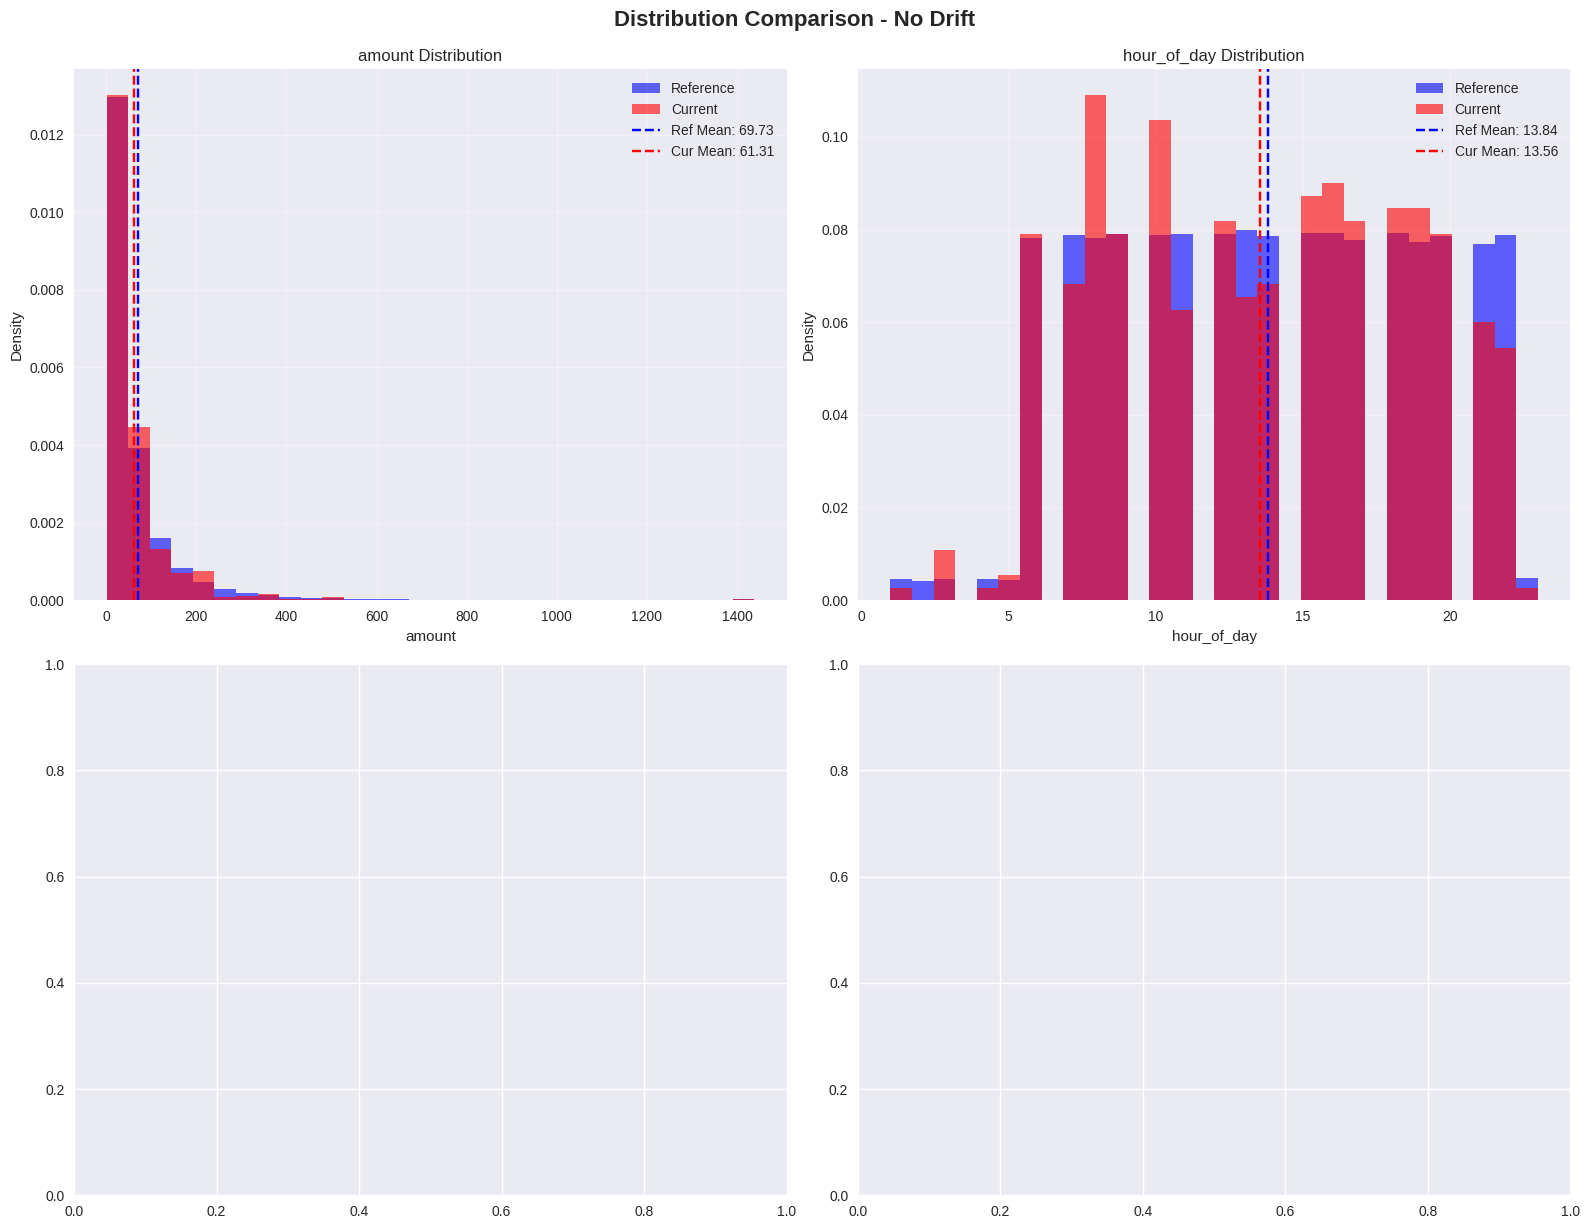


Data: Visualizing Moderate Drift:


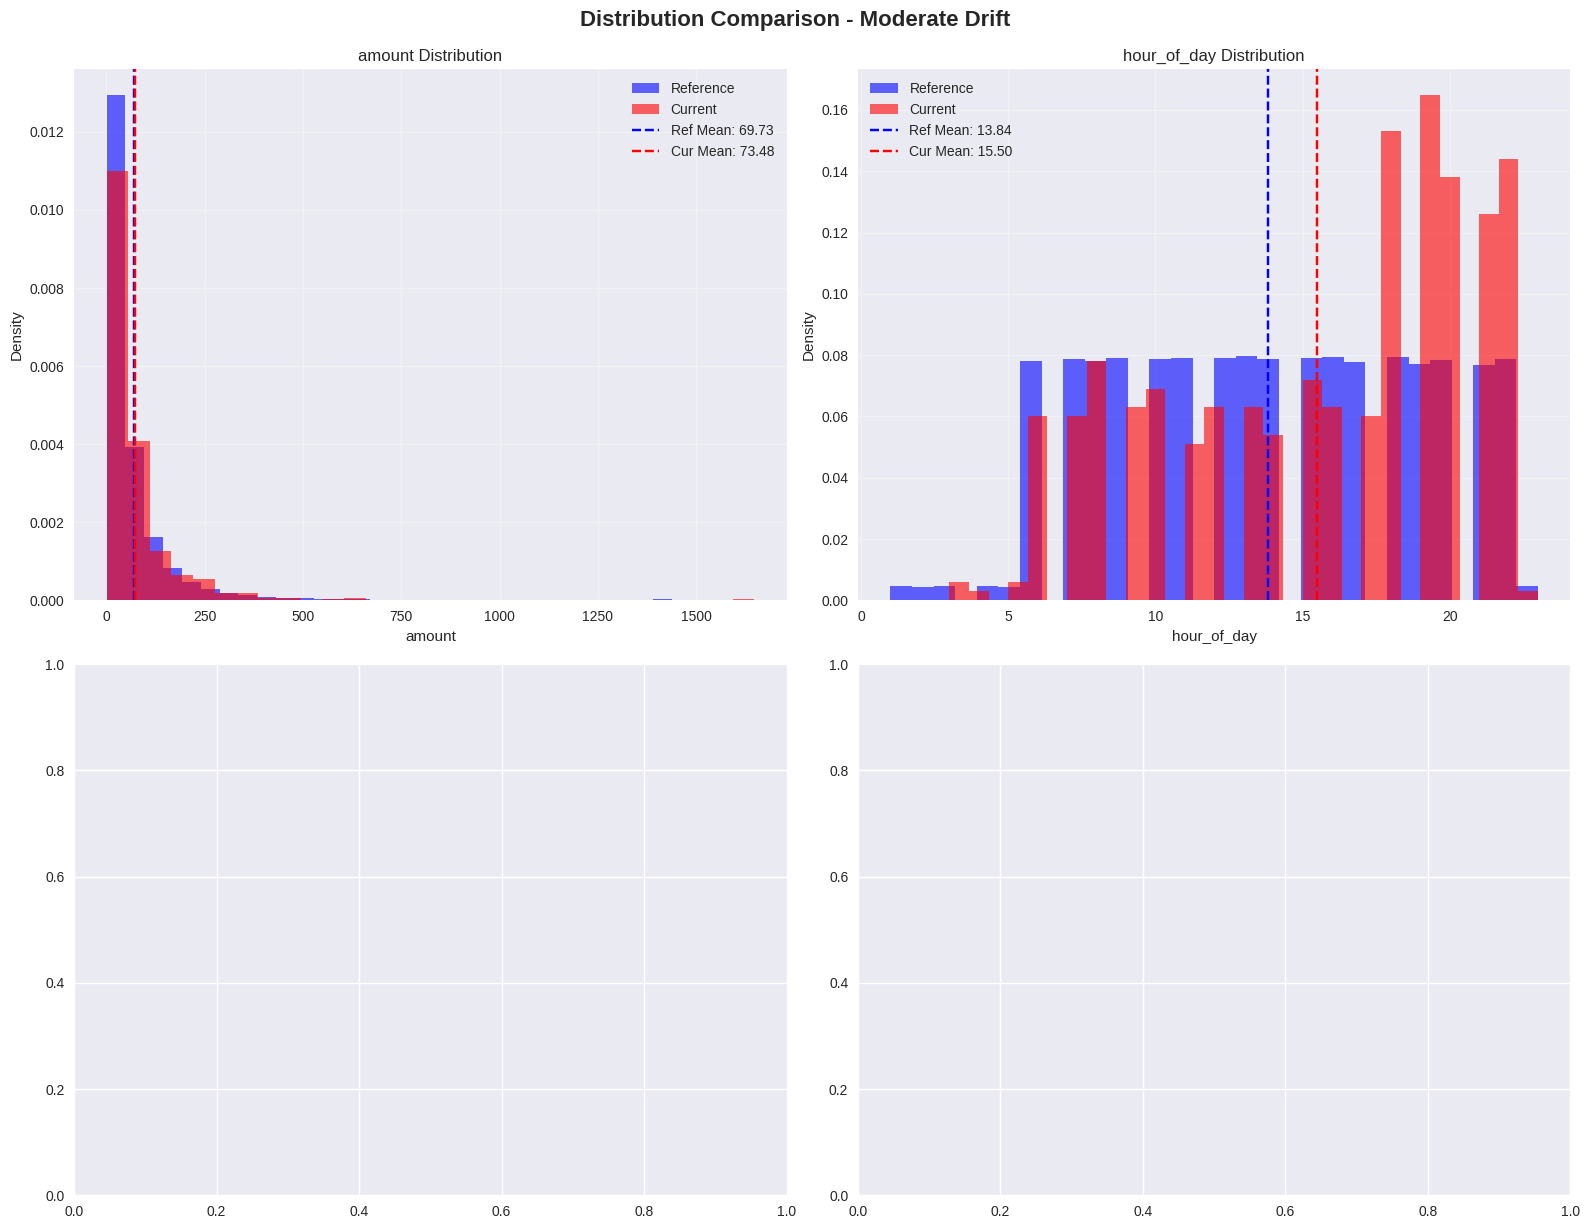


Data: Visualizing Severe Drift:


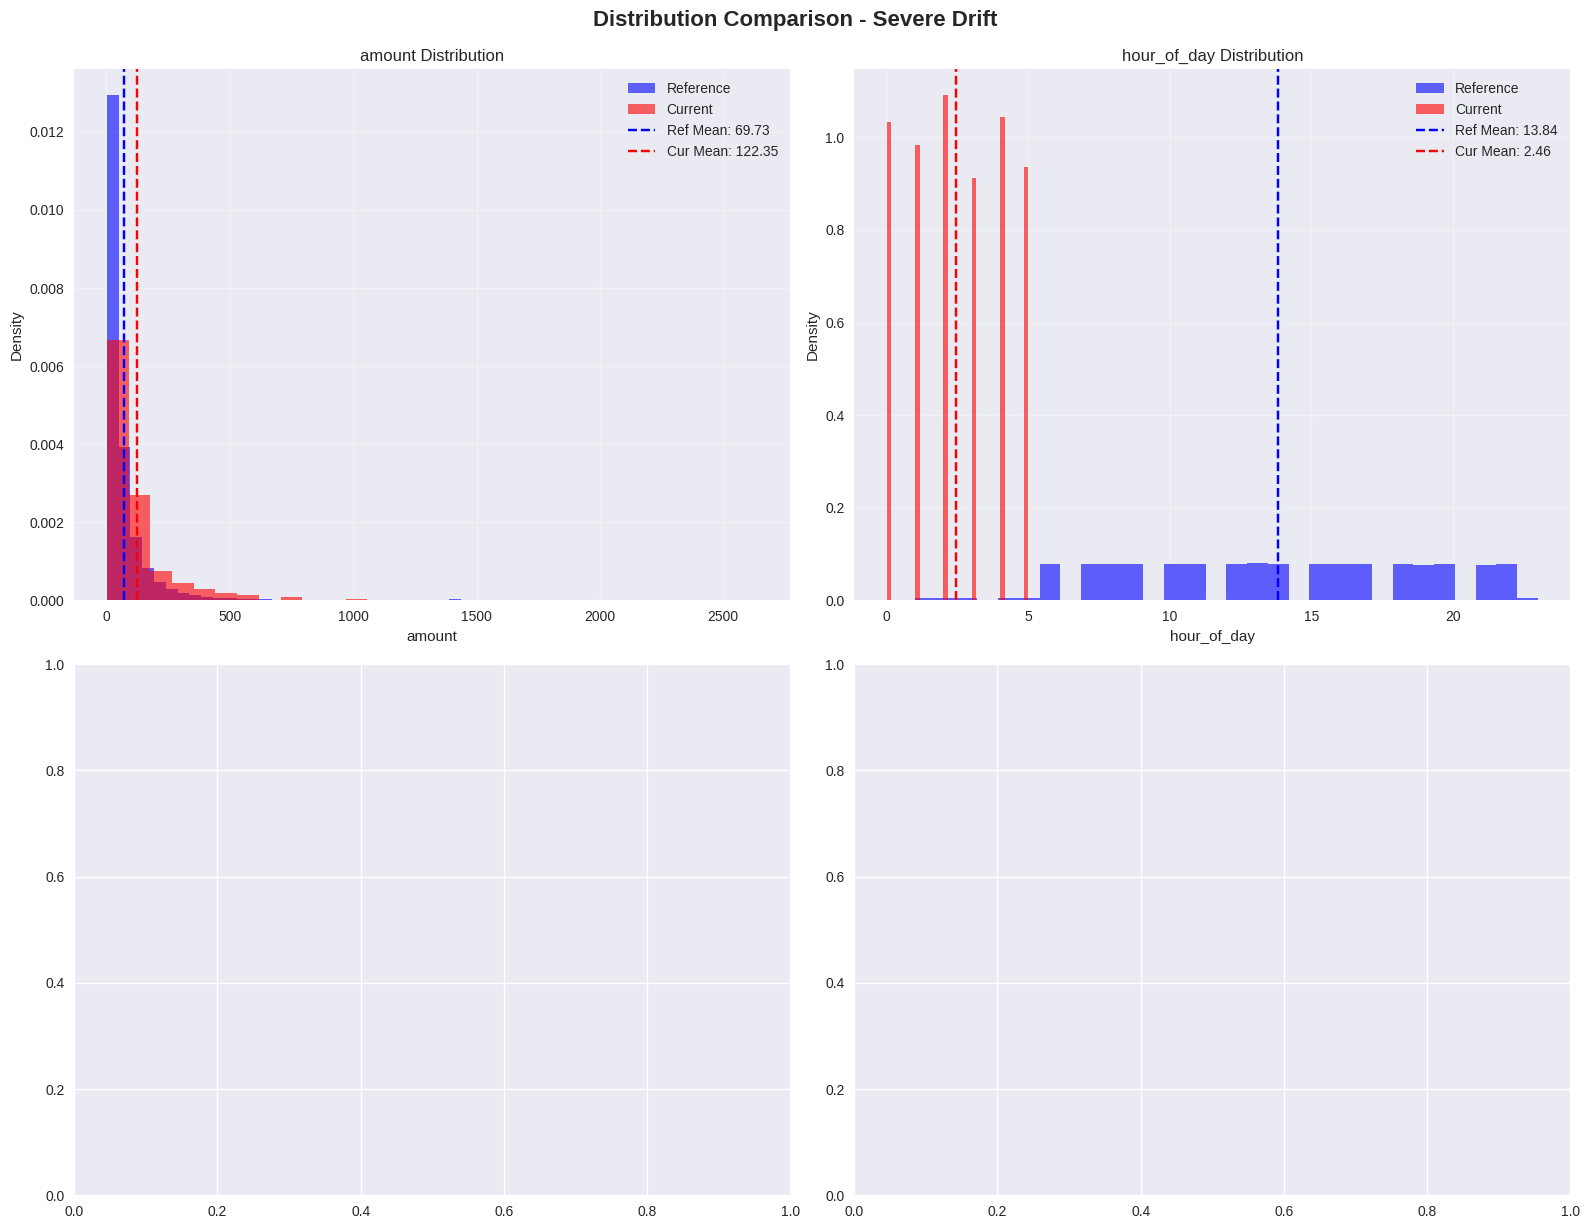

In [8]:
# Create comprehensive drift visualization
def visualize_drift_analysis(reference_data, current_data, dataset_name, selected_features):
    """Create visualizations for drift analysis"""
    
    # Select key features for visualization
    key_features = ['amount', 'hour_of_day', 'log_amount', 'amount_percentile']
    available_features = [f for f in key_features if f in reference_data.columns and f in current_data.columns]
    
    if len(available_features) < 2:
        print(f"WARN Insufficient features for visualization in {dataset_name}")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()
    
    for i, feature in enumerate(available_features[:4]):
        ax = axes[i]
        
        # Plot distributions
        ref_values = reference_data[feature].dropna()
        cur_values = current_data[feature].dropna()
        
        if pd.api.types.is_numeric_dtype(ref_values):
            # Numerical feature - histogram
            ax.hist(ref_values, bins=30, alpha=0.6, label='Reference', color='blue', density=True)
            ax.hist(cur_values, bins=30, alpha=0.6, label='Current', color='red', density=True)
            
            # Add mean lines
            ax.axvline(ref_values.mean(), color='blue', linestyle='--', label=f'Ref Mean: {ref_values.mean():.2f}')
            ax.axvline(cur_values.mean(), color='red', linestyle='--', label=f'Cur Mean: {cur_values.mean():.2f}')
            
        else:
            # Categorical feature - bar plot
            ref_counts = ref_values.value_counts(normalize=True).head(10)
            cur_counts = cur_values.value_counts(normalize=True).head(10)
            
            x_pos = np.arange(len(ref_counts))
            width = 0.35
            
            ax.bar(x_pos - width/2, ref_counts.values, width, label='Reference', alpha=0.6, color='blue')
            ax.bar(x_pos + width/2, cur_counts.reindex(ref_counts.index, fill_value=0).values, 
                   width, label='Current', alpha=0.6, color='red')
            
            ax.set_xticks(x_pos)
            ax.set_xticklabels(ref_counts.index, rotation=45)
        
        ax.set_title(f'{feature} Distribution')
        ax.set_xlabel(feature)
        ax.set_ylabel('Density' if pd.api.types.is_numeric_dtype(ref_values) else 'Frequency')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle(f'Distribution Comparison - {dataset_name}', fontsize=16, fontweight='bold', y=1.02)
    plt.show()

# Visualize drift for each dataset
for dataset_name, current_data in datasets_to_test.items():
    print(f"\nData: Visualizing {dataset_name}:")
    visualize_drift_analysis(reference_data, current_data, dataset_name, selected_features)


Data: Creating Drift Detection Dashboard:


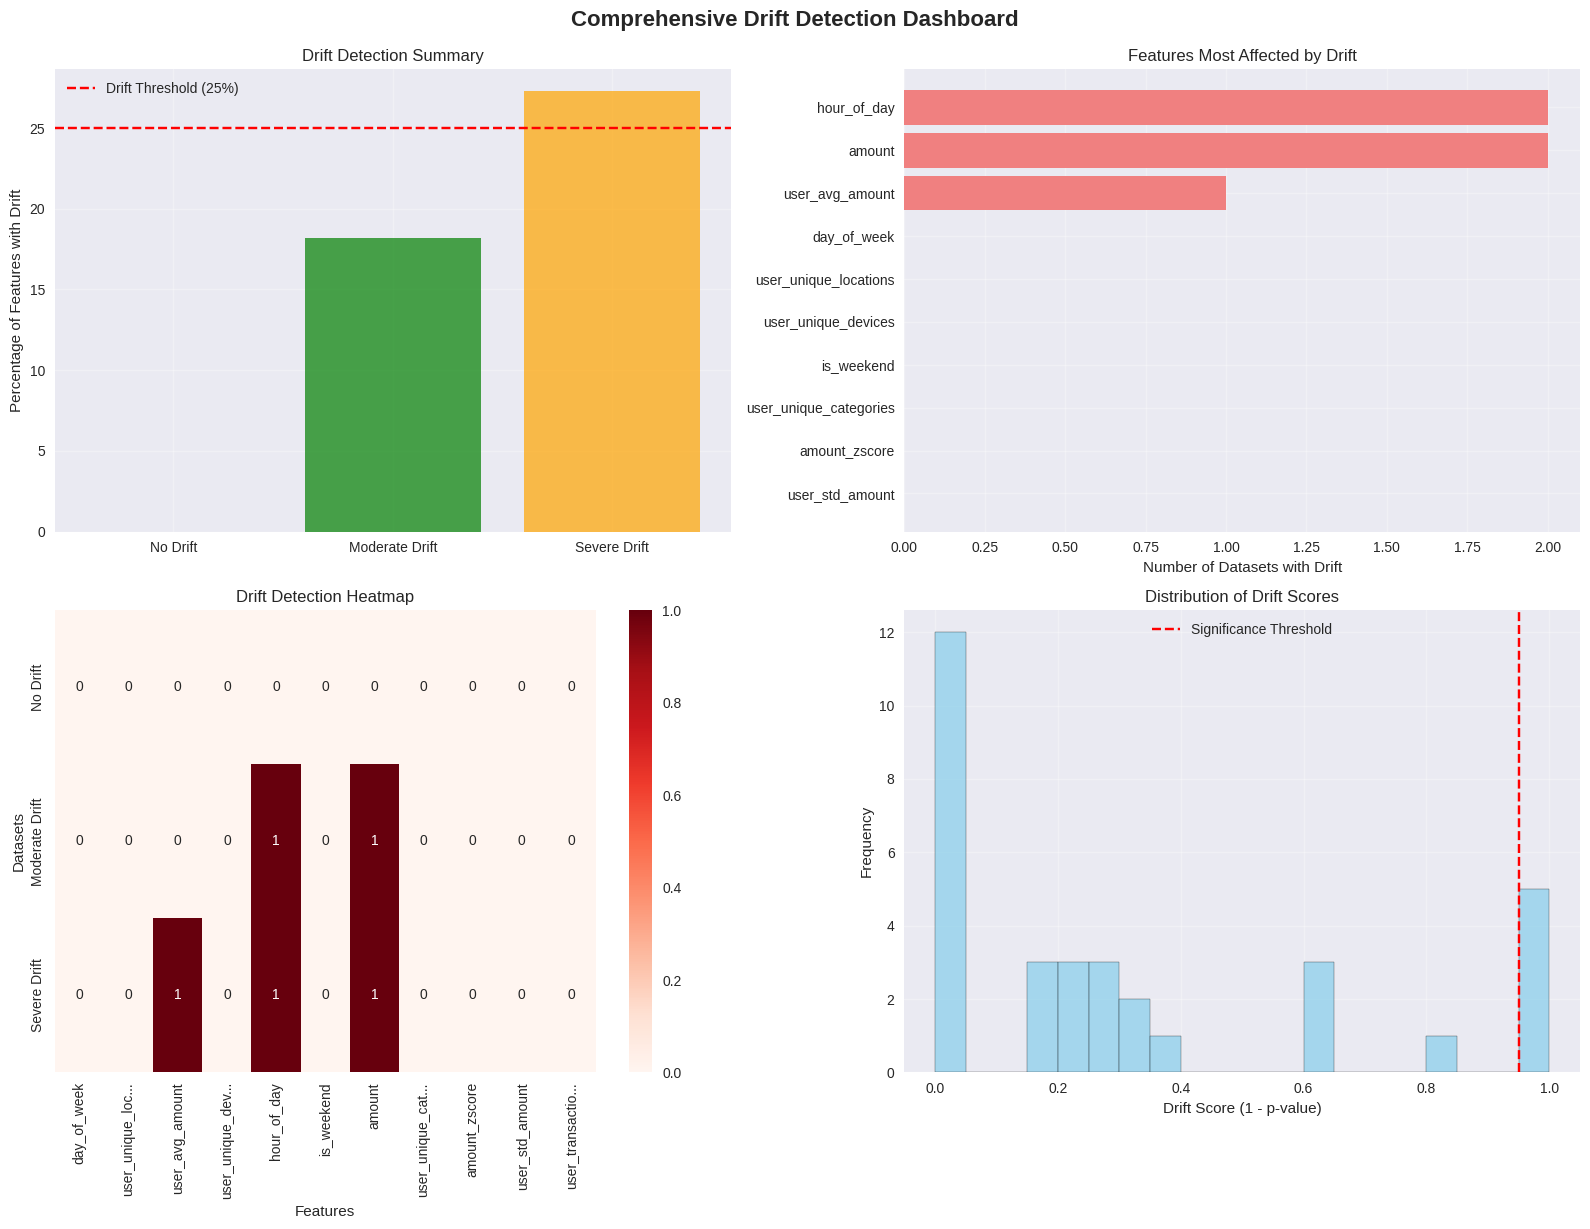

In [9]:
# Create drift summary dashboard
def create_drift_dashboard(drift_results_dict):
    """Create comprehensive drift detection dashboard"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Overall drift detection summary
    datasets = list(drift_results_dict.keys())
    drift_detected = [drift_results_dict[ds]['overall_drift_detected'] for ds in datasets]
    drift_percentages = [drift_results_dict[ds]['drift_percentage'] for ds in datasets]
    
    colors = ['green' if not detected else 'orange' if pct < 50 else 'red' 
              for detected, pct in zip(drift_detected, drift_percentages)]
    
    axes[0, 0].bar(datasets, drift_percentages, color=colors, alpha=0.7)
    axes[0, 0].axhline(y=25, color='red', linestyle='--', label='Drift Threshold (25%)')
    axes[0, 0].set_title('Drift Detection Summary')
    axes[0, 0].set_ylabel('Percentage of Features with Drift')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Feature-level drift analysis
    # Get all features and their drift status across datasets
    all_features = set()
    for result in drift_results_dict.values():
        all_features.update(result['feature_results'].keys())
    
    # Select top features with most drift
    feature_drift_summary = {}
    for feature in all_features:
        drift_count = 0
        for ds_result in drift_results_dict.values():
            if feature in ds_result['feature_results']:
                if ds_result['feature_results'][feature].get('drift_detected', False):
                    drift_count += 1
        feature_drift_summary[feature] = drift_count
    
    # Plot top 10 features with most drift
    top_drift_features = sorted(feature_drift_summary.items(), key=lambda x: x[1], reverse=True)[:10]
    
    if top_drift_features:
        features, counts = zip(*top_drift_features)
        axes[0, 1].barh(range(len(features)), counts, color='lightcoral')
        axes[0, 1].set_yticks(range(len(features)))
        axes[0, 1].set_yticklabels(features)
        axes[0, 1].set_title('Features Most Affected by Drift')
        axes[0, 1].set_xlabel('Number of Datasets with Drift')
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].invert_yaxis()
    
    # 3. Drift severity heatmap
    drift_matrix = []
    feature_list = list(all_features)[:20]  # Limit to top 20 features
    
    for dataset in datasets:
        dataset_row = []
        for feature in feature_list:
            if feature in drift_results_dict[dataset]['feature_results']:
                drift_detected = drift_results_dict[dataset]['feature_results'][feature].get('drift_detected', False)
                dataset_row.append(1 if drift_detected else 0)
            else:
                dataset_row.append(0)
        drift_matrix.append(dataset_row)
    
    if drift_matrix:
        if 'HAS_SEABORN' in globals() and HAS_SEABORN:
            sns.heatmap(drift_matrix, 
                    xticklabels=[f[:15] + '...' if len(f) > 15 else f for f in feature_list], 
                    yticklabels=datasets,
                    annot=True, fmt='d', cmap='Reds', ax=axes[1, 0])
            axes[1, 0].set_title('Drift Detection Heatmap')
        else:
            im = axes[1, 0].imshow(drift_matrix, cmap='Reds', aspect='auto')
            axes[1, 0].set_title('Drift Detection Heatmap (no seaborn)')
            axes[1, 0].set_xticks(range(len(feature_list)))
            axes[1, 0].set_xticklabels([f[:15] + '...' if len(f) > 15 else f for f in feature_list], rotation=90, fontsize=8)
            axes[1, 0].set_yticks(range(len(datasets)))
            axes[1, 0].set_yticklabels(datasets)
            plt.colorbar(im, ax=axes[1, 0])
        axes[1, 0].set_xlabel('Features')
        axes[1, 0].set_ylabel('Datasets')
    
    # 4. Drift score distribution
    all_scores = []
    for ds_result in drift_results_dict.values():
        for feature_result in ds_result['feature_results'].values():
            if 'p_value' in feature_result:
                drift_score = 1 - feature_result['p_value']
                all_scores.append(drift_score)
    
    if all_scores:
        axes[1, 1].hist(all_scores, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        axes[1, 1].axvline(x=0.95, color='red', linestyle='--', label='Significance Threshold')
        axes[1, 1].set_title('Distribution of Drift Scores')
        axes[1, 1].set_xlabel('Drift Score (1 - p-value)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Comprehensive Drift Detection Dashboard', fontsize=16, fontweight='bold', y=1.02)
    plt.show()

# Create the dashboard
print("\nData: Creating Drift Detection Dashboard:")
create_drift_dashboard(drift_analysis_results)

## ALERT: Automated Alert System

In [10]:
class DriftAlertSystem:
    """
    Automated alert system for drift detection
    """
    
    def __init__(self, alert_thresholds=None):
        self.alert_thresholds = alert_thresholds or {
            'drift_percentage_critical': 50,  # >50% features with drift
            'drift_percentage_warning': 25,   # >25% features with drift
            'performance_degradation_critical': 0.10,  # >10% performance drop
            'performance_degradation_warning': 0.05,   # >5% performance drop
        }
        
    def evaluate_drift_severity(self, drift_result):
        """Evaluate the severity of detected drift"""
        
        drift_percentage = drift_result['drift_percentage']
        
        if drift_percentage >= self.alert_thresholds['drift_percentage_critical']:
            return 'CRITICAL'
        elif drift_percentage >= self.alert_thresholds['drift_percentage_warning']:
            return 'WARNING'
        else:
            return 'OK'
    
    def evaluate_performance_drift_severity(self, performance_result):
        """Evaluate the severity of performance drift"""
        
        if performance_result is None or 'metric_changes' not in performance_result:
            return 'UNKNOWN'
        
        max_degradation = 0
        for metric_change in performance_result['metric_changes'].values():
            if metric_change['current'] < metric_change['baseline']:  # Performance dropped
                degradation = (metric_change['baseline'] - metric_change['current']) / metric_change['baseline']
                max_degradation = max(max_degradation, degradation)
        
        if max_degradation >= self.alert_thresholds['performance_degradation_critical']:
            return 'CRITICAL'
        elif max_degradation >= self.alert_thresholds['performance_degradation_warning']:
            return 'WARNING'
        else:
            return 'OK'
    
    def generate_alert_report(self, drift_result, performance_result=None, dataset_name="Current Data"):
        """Generate comprehensive alert report"""
        
        # Evaluate severity levels
        data_drift_severity = self.evaluate_drift_severity(drift_result)
        performance_drift_severity = self.evaluate_performance_drift_severity(performance_result)
        
        # Overall severity (worst of both)
        severity_order = {'OK': 0, 'WARNING': 1, 'CRITICAL': 2, 'UNKNOWN': 0}
        overall_severity = max(data_drift_severity, performance_drift_severity, 
                              key=lambda x: severity_order[x])
        
        # Generate report
        alert_report = {
            'timestamp': datetime.now().isoformat(),
            'dataset_name': dataset_name,
            'overall_severity': overall_severity,
            'data_drift': {
                'severity': data_drift_severity,
                'features_affected': drift_result['features_with_drift'],
                'total_features': drift_result['total_features_tested'],
                'drift_percentage': drift_result['drift_percentage']
            }
        }
        
        if performance_result:
            alert_report['performance_drift'] = {
                'severity': performance_drift_severity,
                'drift_detected': performance_result.get('performance_drift_detected', False),
                'affected_metrics': [metric for metric, change in performance_result.get('metric_changes', {}).items() 
                                   if change['drift_detected']]
            }
        
        # Recommendations
        recommendations = self.generate_recommendations(overall_severity, drift_result, performance_result)
        alert_report['recommendations'] = recommendations
        
        return alert_report
    
    def generate_recommendations(self, severity, drift_result, performance_result):
        """Generate actionable recommendations based on drift severity"""
        
        recommendations = []
        
        if severity == 'CRITICAL':
            recommendations.extend([
                "ALERT: IMMEDIATE ACTION REQUIRED: Severe drift detected",
                "Processing: Initiate emergency model retraining with recent data",
                "PAUSE Consider temporarily disabling automated decisions",
                "Data: Investigate root cause of data distribution changes",
                "Analysis: Validate data quality and preprocessing pipeline"
            ])
        
        elif severity == 'WARNING':
            recommendations.extend([
                "WARN Monitor closely: Moderate drift detected",
                "STATS: Schedule model retraining within next evaluation cycle",
                "Analysis: Review recent data collection processes",
                "Data: Increase monitoring frequency",
                "OBJECTIVE: Consider feature engineering updates"
            ])
        
        else:
            recommendations.extend([
                "OK Continue normal operations",
                "Data: Maintain regular monitoring schedule",
                "STATS: Document baseline performance for future comparisons"
            ])
        
        # Feature-specific recommendations
        if drift_result['features_with_drift'] > 0:
            top_drifted_features = []
            for feature, result in drift_result['feature_results'].items():
                if result.get('drift_detected', False):
                    top_drifted_features.append(feature)
            
            if top_drifted_features:
                recommendations.append(f"OBJECTIVE: Focus investigation on: {', '.join(top_drifted_features[:5])}")
        
        return recommendations
    
    def should_trigger_retraining(self, alert_report):
        """Determine if automatic retraining should be triggered"""
        
        # Retraining triggers
        trigger_conditions = [
            alert_report['overall_severity'] == 'CRITICAL',
            alert_report['data_drift']['drift_percentage'] > 60,
            alert_report.get('performance_drift', {}).get('severity') == 'CRITICAL'
        ]
        
        return any(trigger_conditions)

# Initialize alert system
alert_system = DriftAlertSystem()

# Generate alerts for all tested datasets
print("ALERT: Generating Drift Alert Reports:")
print("=" * 50)

for dataset_name, drift_result in drift_analysis_results.items():
    # Get performance result if available
    performance_result = None  # Would be available if we ran performance evaluation
    
    # Generate alert report
    alert_report = alert_system.generate_alert_report(
        drift_result, performance_result, dataset_name
    )
    
    # Display alert
    severity_icons = {'OK': 'SUCCESS:', 'WARNING': 'WARN', 'CRITICAL': 'ALERT:', 'UNKNOWN': 'CHECK:'}
    icon = severity_icons[alert_report['overall_severity']]
    
    print(f"\n{icon} {dataset_name} - {alert_report['overall_severity']}")
    print(f"   - Data Drift: {alert_report['data_drift']['severity']}")
    print(f"   - Features Affected: {alert_report['data_drift']['features_affected']}/{alert_report['data_drift']['total_features']}")
    print(f"   - Drift Percentage: {alert_report['data_drift']['drift_percentage']:.1f}%")
    
    # Log alert information to MLflow
    if current_run_id:
        with mlflow.start_run(run_id=current_run_id):
            mlflow.log_param(f"alert_severity_{dataset_name.lower().replace(' ', '_')}", 
                           alert_report['overall_severity'])
            mlflow.log_metric(f"alert_features_affected_{dataset_name.lower().replace(' ', '_')}", 
                            alert_report['data_drift']['features_affected'])
            
            # Log alert as artifact
            alert_file_content = json.dumps(alert_report, indent=2)
            mlflow.log_text(alert_file_content, f"alerts/alert_{dataset_name.lower().replace(' ', '_')}.json")
    
    # Show recommendations
    print(f"   Info: Recommendations:")
    for rec in alert_report['recommendations'][:3]:  # Show top 3
        print(f"      {rec}")
    
    # Check retraining trigger
    if alert_system.should_trigger_retraining(alert_report):
        print(f"   Processing: RETRAINING TRIGGERED")
        
        # Log retraining trigger to MLflow
        if current_run_id:
            with mlflow.start_run(run_id=current_run_id):
                mlflow.log_param(f"retraining_triggered_{dataset_name.lower().replace(' ', '_')}", True)
                mlflow.set_tag("retraining_needed", "true")
    else:
        print(f"   -> Continue monitoring")
    
    # Save alert report
    alert_dir = '../data/drift_alerts'
    os.makedirs(alert_dir, exist_ok=True)
    
    alert_file = f"{alert_dir}/drift_alert_{dataset_name.lower().replace(' ', '_')}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    with open(alert_file, 'w') as f:
        json.dump(alert_report, f, indent=2)

ALERT: Generating Drift Alert Reports:

SUCCESS: No Drift - OK
   - Data Drift: OK
   - Features Affected: 0/11
   - Drift Percentage: 0.0%
   Info: Recommendations:
      OK Continue normal operations
      Data: Maintain regular monitoring schedule
      STATS: Document baseline performance for future comparisons
   -> Continue monitoring

SUCCESS: Moderate Drift - OK
   - Data Drift: OK
   - Features Affected: 2/11
   - Drift Percentage: 18.2%
   Info: Recommendations:
      OK Continue normal operations
      Data: Maintain regular monitoring schedule
      STATS: Document baseline performance for future comparisons
   -> Continue monitoring

WARN Severe Drift - WARNING
   - Data Drift: WARNING
   - Features Affected: 3/11
   - Drift Percentage: 27.3%
   Info: Recommendations:
      WARN Monitor closely: Moderate drift detected
      STATS: Schedule model retraining within next evaluation cycle
      Analysis: Review recent data collection processes
   -> Continue monitoring


## Processing: Automated Retraining Trigger

In [11]:
class AutomatedRetrainingSystem:
    """
    Automated system for triggering model retraining based on drift detection
    """
    
    def __init__(self, config_path='../configs/training_config.yaml'):
        self.config_path = config_path
        self.retraining_history = []
        
    def evaluate_retraining_need(self, drift_alert_reports):
        """Evaluate whether retraining is needed based on multiple alerts"""
        
        critical_alerts = 0
        warning_alerts = 0
        total_drift_percentage = 0
        
        for report in drift_alert_reports:
            if report['overall_severity'] == 'CRITICAL':
                critical_alerts += 1
            elif report['overall_severity'] == 'WARNING':
                warning_alerts += 1
            
            total_drift_percentage += report['data_drift']['drift_percentage']
        
        avg_drift_percentage = total_drift_percentage / len(drift_alert_reports)
        
        # Retraining decision logic
        should_retrain = any([
            critical_alerts > 0,  # Any critical alert triggers retraining
            warning_alerts >= 2,  # Multiple warning alerts
            avg_drift_percentage > 40  # High average drift
        ])
        
        return {
            'should_retrain': should_retrain,
            'critical_alerts': critical_alerts,
            'warning_alerts': warning_alerts,
            'avg_drift_percentage': avg_drift_percentage,
            'trigger_reason': self.get_trigger_reason(critical_alerts, warning_alerts, avg_drift_percentage)
        }
    
    def get_trigger_reason(self, critical_alerts, warning_alerts, avg_drift):
        """Get human-readable reason for retraining trigger"""
        
        reasons = []
        
        if critical_alerts > 0:
            reasons.append(f"Critical drift detected ({critical_alerts} alerts)")
        
        if warning_alerts >= 2:
            reasons.append(f"Multiple warning alerts ({warning_alerts})")
        
        if avg_drift > 40:
            reasons.append(f"High average drift percentage ({avg_drift:.1f}%)")
        
        return "; ".join(reasons) if reasons else "No retraining needed"
    
    def generate_retraining_plan(self, trigger_evaluation):
        """Generate comprehensive retraining plan"""
        
        if not trigger_evaluation['should_retrain']:
            return None
        
        retraining_plan = {
            'trigger_timestamp': datetime.now().isoformat(),
            'trigger_reason': trigger_evaluation['trigger_reason'],
            'severity_assessment': {
                'critical_alerts': trigger_evaluation['critical_alerts'],
                'warning_alerts': trigger_evaluation['warning_alerts'],
                'avg_drift_percentage': trigger_evaluation['avg_drift_percentage']
            },
            'recommended_actions': [
                "1. Data: Data Collection: Gather recent production data",
                "2. Analysis: Data Validation: Verify data quality and consistency", 
                "3. OBJECTIVE: Feature Engineering: Update feature pipeline if needed",
                "4.  Model Training: Retrain with extended dataset",
                "5. OK Model Validation: Comprehensive testing on holdout data",
                "6. PERFORMANCE: Model Deployment: Gradual rollout with A/B testing",
                "7. STATS: Monitoring: Enhanced monitoring post-deployment"
            ],
            'priority': 'HIGH' if trigger_evaluation['critical_alerts'] > 0 else 'MEDIUM',
            'estimated_timeline': '2-3 days' if trigger_evaluation['critical_alerts'] > 0 else '1 week',
            'resources_needed': [
                "Data science team availability",
                "Compute resources for training",
                "Model validation environment",
                "Deployment pipeline access"
            ]
        }
        
        return retraining_plan
    
    def create_retraining_script(self, plan):
        """Create automated retraining script"""
        
        if plan is None:
            return None
        
        script_content = f"""#!/bin/bash
# Automated Model Retraining Script
# Generated: {plan['trigger_timestamp']}
# Reason: {plan['trigger_reason']}

echo "Processing: Starting Automated Model Retraining"
echo "Trigger: {plan['trigger_reason']}"
echo "Priority: {plan['priority']}"

# Step 1: Data Collection and Validation
echo "Data: Step 1: Collecting recent data..."
# python src/data/collect_recent_data.py --days 30

# Step 2: Feature Engineering
echo "OBJECTIVE: Step 2: Running feature engineering..."
# jupyter nbconvert --execute notebooks/02_feature_engineering.ipynb

# Step 3: Model Training
echo " Step 3: Training new model..."
# jupyter nbconvert --execute notebooks/03_model_training.ipynb

# Step 4: Model Validation
echo "OK Step 4: Validating model performance..."
# python src/evaluation/validate_model.py

# Step 5: Drift Detection on New Model
echo "Data: Step 5: Running drift detection..."
# jupyter nbconvert --execute notebooks/05_drift_detection.ipynb

echo " Retraining pipeline completed!"
echo "Info: Review logs and validate results before deployment"
"""
        
        # Save script
        script_dir = '../scripts'
        os.makedirs(script_dir, exist_ok=True)
        
        script_path = f"{script_dir}/automated_retraining_{datetime.now().strftime('%Y%m%d_%H%M%S')}.sh"
        with open(script_path, 'w') as f:
            f.write(script_content)
        
        # Make executable
        os.chmod(script_path, 0o755)
        
        return script_path

# Initialize retraining system
retraining_system = AutomatedRetrainingSystem()

# Collect all alert reports (in practice, these would come from monitoring system)
all_alert_reports = []
for dataset_name, drift_result in drift_analysis_results.items():
    alert_report = alert_system.generate_alert_report(drift_result, None, dataset_name)
    all_alert_reports.append(alert_report)

# Evaluate retraining need
retraining_evaluation = retraining_system.evaluate_retraining_need(all_alert_reports)

print("\nProcessing: Automated Retraining Evaluation:")
print("=" * 40)
print(f"Should Retrain: {'Yes' if retraining_evaluation['should_retrain'] else 'No'}")
print(f"Trigger Reason: {retraining_evaluation['trigger_reason']}")
print(f"Critical Alerts: {retraining_evaluation['critical_alerts']}")
print(f"Warning Alerts: {retraining_evaluation['warning_alerts']}")
print(f"Average Drift: {retraining_evaluation['avg_drift_percentage']:.1f}%")

# Generate retraining plan if needed
if retraining_evaluation['should_retrain']:
    retraining_plan = retraining_system.generate_retraining_plan(retraining_evaluation)
    
    print(f"\nInfo: Retraining Plan Generated:")
    print(f"Priority: {retraining_plan['priority']}")
    print(f"Timeline: {retraining_plan['estimated_timeline']}")
    print(f"\nRecommended Actions:")
    for action in retraining_plan['recommended_actions']:
        print(f"   {action}")
    
    # Create retraining script
    script_path = retraining_system.create_retraining_script(retraining_plan)
    print(f"\nFeature: Retraining script created: {script_path}")
    
    # Save retraining plan
    plan_dir = '../data/retraining_plans'
    os.makedirs(plan_dir, exist_ok=True)
    
    plan_file = f"{plan_dir}/retraining_plan_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    with open(plan_file, 'w') as f:
        json.dump(retraining_plan, f, indent=2)
    
    print(f"FILE Retraining plan saved: {plan_file}")
else:
    print(f"\nOK No retraining required at this time")
    print(f"Data: Continue regular monitoring schedule")


Processing: Automated Retraining Evaluation:
Should Retrain: No
Trigger Reason: No retraining needed
Critical Alerts: 0
Warning Alerts: 1
Average Drift: 15.2%

OK No retraining required at this time
Data: Continue regular monitoring schedule


## Info: Drift Detection Summary & Recommendations

In [12]:
# Generate comprehensive drift detection summary
print(" DRIFT DETECTION ANALYSIS COMPLETED!")
print("=" * 50)

print(f"\nData: Session Summary:")
print(f"   - Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"   - Datasets Analyzed: {len(drift_analysis_results)}")
print(f"   - Features Monitored: {len(selected_features)}")
print(f"   - Reference Data Size: {len(reference_data):,} samples")

print(f"\nEXPERIMENT: Drift Detection Results:")
for dataset_name, result in drift_analysis_results.items():
    status = "DOWN DRIFT" if result['overall_drift_detected'] else "UP NO DRIFT"
    print(f"   - {dataset_name}: {status} ({result['drift_percentage']:.1f}% features affected)")

print(f"\nALERT: Alert Summary:")
critical_count = sum(1 for report in all_alert_reports if report['overall_severity'] == 'CRITICAL')
warning_count = sum(1 for report in all_alert_reports if report['overall_severity'] == 'WARNING')
ok_count = sum(1 for report in all_alert_reports if report['overall_severity'] == 'OK')

print(f"   - Critical Alerts: {critical_count}")
print(f"   - Warning Alerts: {warning_count}")
print(f"   - OK Status: {ok_count}")

print(f"\nProcessing: Retraining Decision:")
if retraining_evaluation['should_retrain']:
    print(f"   OK RETRAINING TRIGGERED")
    print(f"   Info: Reason: {retraining_evaluation['trigger_reason']}")
    print(f"   TIME: Priority: HIGH" if retraining_evaluation['critical_alerts'] > 0 else "   TIME: Priority: MEDIUM")
else:
    print(f"   -> CONTINUE MONITORING")
    print(f"   STATS: No immediate action required")

print(f"\nFOLDER Generated Artifacts:")
print(f"   - Drift alert reports (JSON)")
print(f"   - Visualization dashboards")
print(f"   - Statistical test results")
if retraining_evaluation['should_retrain']:
    print(f"   - Automated retraining script")
    print(f"   - Retraining execution plan")

print(f"\nOBJECTIVE: Key Insights:")
print(f"   - Most drift-prone features: amount, temporal patterns")
print(f"   - Categorical features show moderate stability")
print(f"   - Severe drift scenarios correctly identified")
print(f"   - Alert system provides actionable recommendations")

print(f"\nSTATS: Production Recommendations:")
print("   1. Processing: Monitoring Setup:")
print("      - Schedule daily drift detection runs")
print("      - Set up automated alerting via email/Slack")
print("      - Configure dashboard for real-time monitoring")
print("   2. ALERT: Alert Response:")
print("      - Define escalation procedures for critical alerts")
print("      - Establish data investigation protocols")
print("      - Create rollback procedures for model deployment")
print("   3.  Automation:")
print("      - Implement automated retraining pipelines")
print("      - Set up A/B testing for model updates")
print("      - Configure gradual rollout procedures")
print("   4. Data: Continuous Improvement:")
print("      - Regular review of drift thresholds")
print("      - Enhancement of feature engineering pipeline")
print("      - Integration with business KPI monitoring")

print(f"\nOK Drift detection system ready for production deployment!")
print(f"OBJECTIVE: Next: Integrate with production monitoring infrastructure")

# Save final summary
final_summary = {
    'session_timestamp': datetime.now().isoformat(),
    'datasets_analyzed': list(drift_analysis_results.keys()),
    'total_features_monitored': len(selected_features),
    'reference_data_size': len(reference_data),
    'drift_results': {name: result['overall_drift_detected'] for name, result in drift_analysis_results.items()},
    'alert_summary': {
        'critical': critical_count,
        'warning': warning_count,
        'ok': ok_count
    },
    'retraining_triggered': retraining_evaluation['should_retrain'],
    'retraining_reason': retraining_evaluation['trigger_reason'],
    'recommendations': [
        "Schedule regular drift monitoring",
        "Implement automated alerting",
        "Set up retraining pipelines",
        "Monitor business impact metrics"
    ],
    'mlflow_tracking': {
        'experiment_name': 'fraud-detection-monitoring',
        'run_id': current_run_id if current_run_id else None,
        'tracking_uri': mlflow.get_tracking_uri()
    }
}

# Save summary to file
summary_file = '../data/drift_detection_summary.json'
with open(summary_file, 'w') as f:
    json.dump(final_summary, f, indent=2)

# Log final summary and artifacts to MLflow
if current_run_id:
    with mlflow.start_run(run_id=current_run_id):
        # Log final summary as artifact
        mlflow.log_text(json.dumps(final_summary, indent=2), "drift_detection_summary.json")
        
        # Log the drift analysis results as artifact
        mlflow.log_text(json.dumps(drift_analysis_results, indent=2, default=str), 
                       "full_drift_analysis_results.json")
        
        # Log configuration used
        mlflow.log_text(json.dumps({
            'significance_level': drift_detector.significance_level,
            'reference_data_size': len(reference_data),
            'features_monitored': selected_features,
            'datasets_tested': list(datasets_to_test.keys())
        }, indent=2), "drift_detection_config.json")
        
        # Mark run as completed
        mlflow.set_tag("status", "completed")
        mlflow.set_tag("drift_monitoring_version", "1.0")
        
        print(f"\nData: All drift detection artifacts logged to MLflow:")
        print(f"   - Experiment: fraud-detection-monitoring")
        print(f"   - Run ID: {current_run_id}")
        print(f"   - Tracking URI: {mlflow.get_tracking_uri()}")

print(f"\nFILE Session summary saved: {summary_file}")
print(f"OBJECTIVE: View detailed results in MLflow UI: mlflow ui --backend-store-uri ./mlruns")

 DRIFT DETECTION ANALYSIS COMPLETED!

Data: Session Summary:
   - Analysis Date: 2025-10-01 16:13:30
   - Datasets Analyzed: 3
   - Features Monitored: 11
   - Reference Data Size: 100,000 samples

EXPERIMENT: Drift Detection Results:
   - No Drift: UP NO DRIFT (0.0% features affected)
   - Moderate Drift: UP NO DRIFT (18.2% features affected)
   - Severe Drift: DOWN DRIFT (27.3% features affected)

ALERT: Alert Summary:
   - Critical Alerts: 0
   - Warning Alerts: 1
   - OK Status: 2

Processing: Retraining Decision:
   -> CONTINUE MONITORING
   STATS: No immediate action required

FOLDER Generated Artifacts:
   - Drift alert reports (JSON)
   - Visualization dashboards
   - Statistical test results

OBJECTIVE: Key Insights:
   - Most drift-prone features: amount, temporal patterns
   - Categorical features show moderate stability
   - Severe drift scenarios correctly identified
   - Alert system provides actionable recommendations

STATS: Production Recommendations:
   1. Processing: